### BRSET

* [Dataset](https://physionet.org/content/brazilian-ophthalmological/1.0.0/)

* [Original Paper](https://www.medrxiv.org/content/10.1101/2024.01.23.24301660v1)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [2]:
PATH = 'datasets/brset/'

In [3]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [4]:
df = pd.read_csv(text_path)
df

,image_id,DR_ICDR,text,DR_2,DR_3,split
0,img00001,0,"An image from the right eye of a male patient,...",0,0,train
1,img00002,0,"An image from the left eye of a male patient, ...",0,0,test
2,img00003,0,An image from the right eye of a female patien...,0,0,train
3,img00004,0,An image from the left eye of a female patient...,0,0,train
4,img00005,0,"An image from the right eye of a male patient,...",0,0,test
...,...,...,...,...,...,...
16261,img16262,1,"An image from the left eye of a male patient, ...",1,1,test
16262,img16263,0,"An image from the right eye of a male patient,...",0,0,train
16263,img16264,0,"An image from the left eye of a male patient, ...",0,0,test
16264,img16265,0,"An image from the right eye of a male patient,...",0,0,train


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'image_id'
label_columns = 'DR_2'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

100%|██████████| 16266/16266 [00:22<00:00, 709.92it/s]


Train Shape: (13012, 6)
Test Shape: (3254, 6)


In [6]:
train_df

,image_id,DR_ICDR,text,DR_2,DR_3,split
0,datasets/brset/images/img00001.jpg,0,"An image from the right eye of a male patient,...",0,0,train
2,datasets/brset/images/img00003.jpg,0,An image from the right eye of a female patien...,0,0,train
3,datasets/brset/images/img00004.jpg,0,An image from the left eye of a female patient...,0,0,train
6,datasets/brset/images/img00007.jpg,0,"An image from the right eye of a male patient,...",0,0,train
7,datasets/brset/images/img00008.jpg,0,"An image from the left eye of a male patient, ...",0,0,train
...,...,...,...,...,...,...
16259,datasets/brset/images/img16260.jpg,0,An image from the left eye of a female patient...,0,0,train
16260,datasets/brset/images/img16261.jpg,1,"An image from the right eye of a male patient,...",1,1,train
16262,datasets/brset/images/img16263.jpg,0,"An image from the right eye of a male patient,...",0,0,train
16264,datasets/brset/images/img16265.jpg,0,"An image from the right eye of a male patient,...",0,0,train


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197121
Epoch 1/15 - Test Accuracy: 0.9388
Epoch 1/15 - Training Time: 559.61 seconds | Inference Time: 136.74 seconds
Epoch 2/15 - Test Accuracy: 0.9404
Epoch 2/15 - Training Time: 533.73 seconds | Inference Time: 131.37 seconds
Epoch 3/15 - Test Accuracy: 0.9496
Epoch 3/15 - Training Time: 534.54 seconds | Inference Time: 130.92 seconds
Epoch 4/15 - Test Accuracy: 0.9511
Epoch 4/15 - Training Time: 535.22 seconds | Inference Time: 131.16 seconds
Epoch 5/15 - Test Accuracy: 0.9474
Epoch 5/15 - Training Time: 533.88 seconds | Inference Time: 131.97 seconds
Epoch 6/15 - Test Accuracy: 0.9484
Epoch 6/15 - Training Time: 532.74 seconds | Inference Time: 131.71 seconds
Epoch 7/15 - Test Accuracy: 0.9481
Epoch 7/15 - Training Time: 533.98 seconds | Inference Time: 131.21 seconds
Epoch 8/15 - Test Accuracy: 0.9425
Epoch 8/15 - Training Time: 532.14 seconds | Inference Time: 131.47 seconds
Epoch 9/15 - Test Accuracy: 0.946

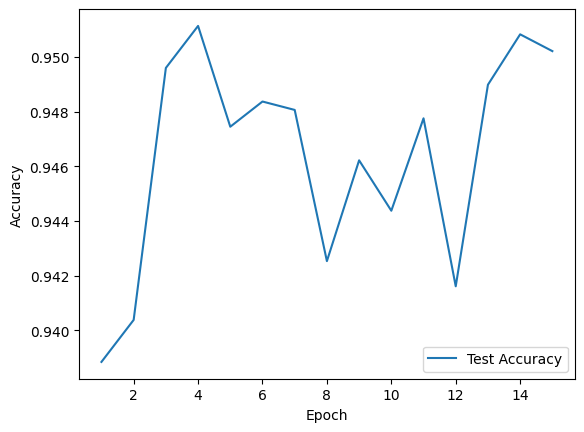

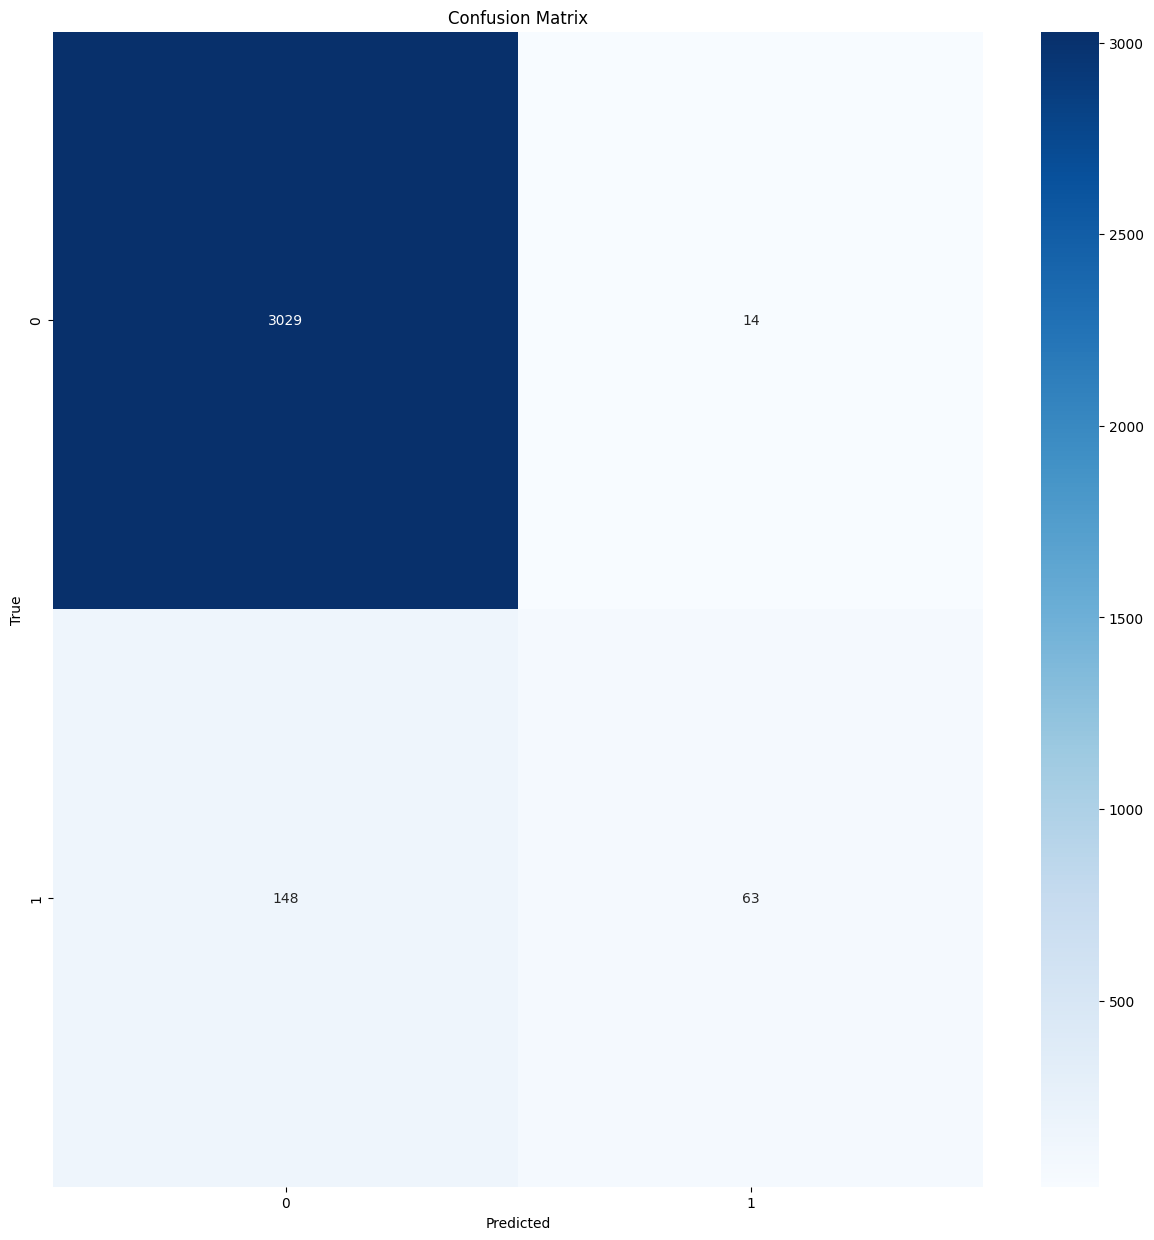

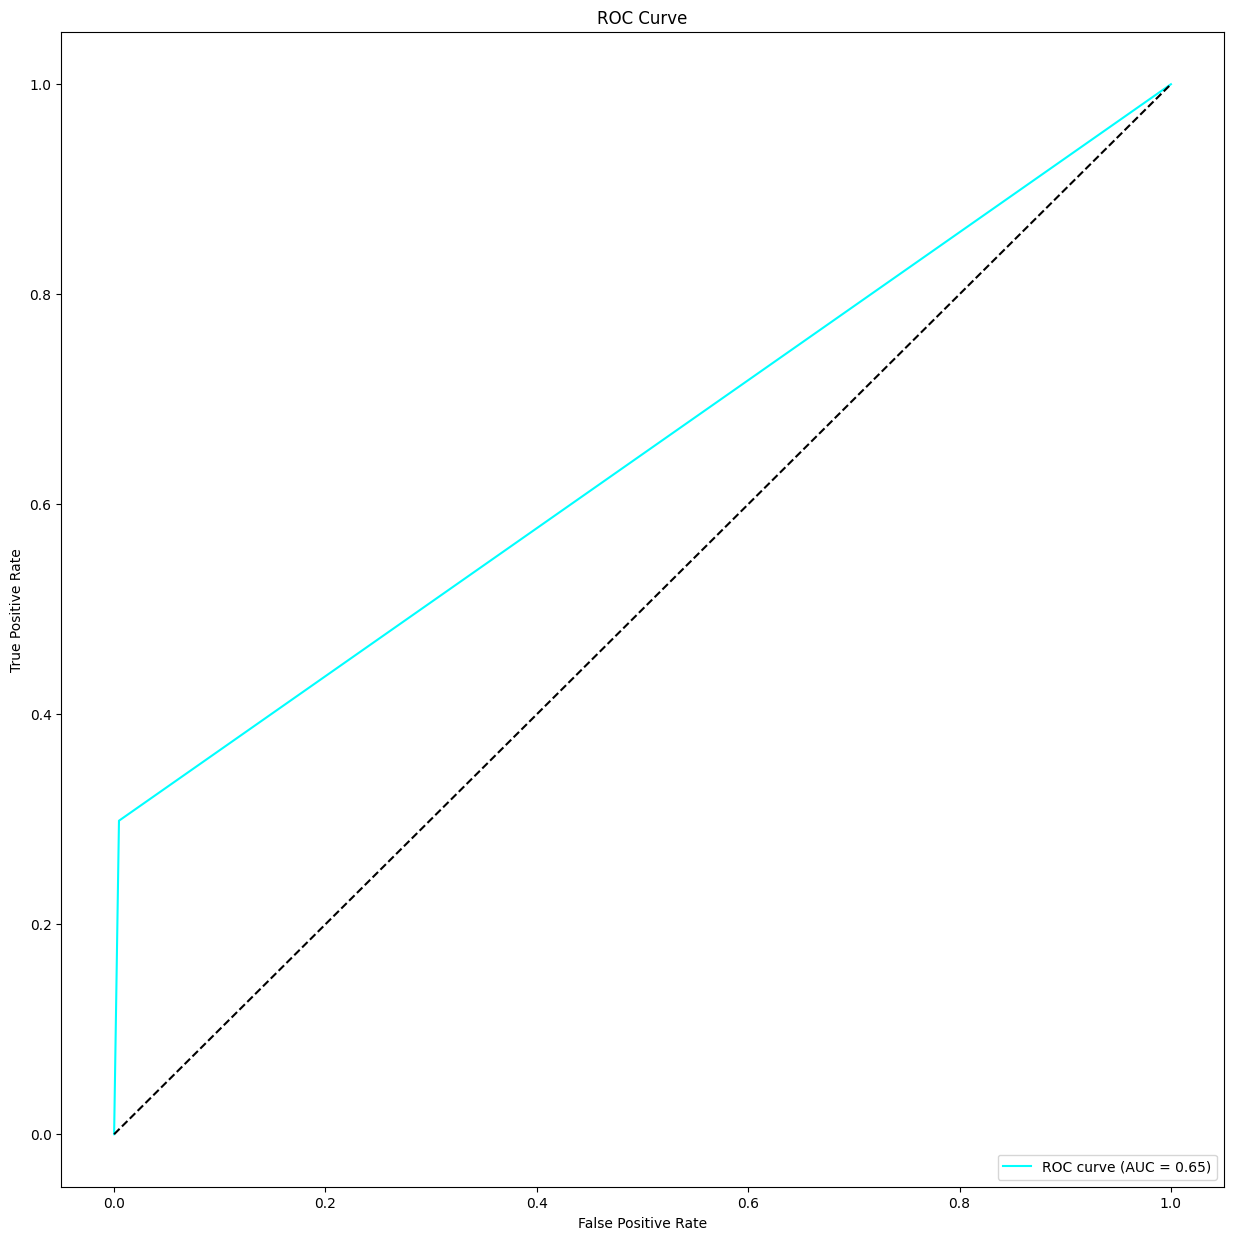

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      3043
         1.0       0.82      0.30      0.44       211

    accuracy                           0.95      3254
   macro avg       0.89      0.65      0.71      3254
weighted avg       0.94      0.95      0.94      3254



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=15, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 98817
Epoch 1/15 - Test Accuracy: 0.9382
Epoch 1/15 - Training Time: 554.90 seconds | Inference Time: 134.39 seconds
Epoch 2/15 - Test Accuracy: 0.9450
Epoch 2/15 - Training Time: 534.69 seconds | Inference Time: 129.75 seconds
Epoch 3/15 - Test Accuracy: 0.9422
Epoch 3/15 - Training Time: 535.94 seconds | Inference Time: 131.17 seconds
Epoch 4/15 - Test Accuracy: 0.9502
Epoch 4/15 - Training Time: 534.35 seconds | Inference Time: 131.00 seconds
Epoch 5/15 - Test Accuracy: 0.9462
Epoch 5/15 - Training Time: 536.72 seconds | Inference Time: 131.23 seconds
Epoch 6/15 - Test Accuracy: 0.9471
Epoch 6/15 - Training Time: 534.43 seconds | Inference Time: 130.80 seconds
Epoch 7/15 - Test Accuracy: 0.9539
Epoch 7/15 - Training Time: 536.02 seconds | Inference Time: 131.14 seconds
Epoch 8/15 - Test Accuracy: 0.9471
Epoch 8/15 - Training Time: 537.96 seconds | Inference Time: 131.61 seconds
Epoch 9/15 - Test Accuracy: 0.9487


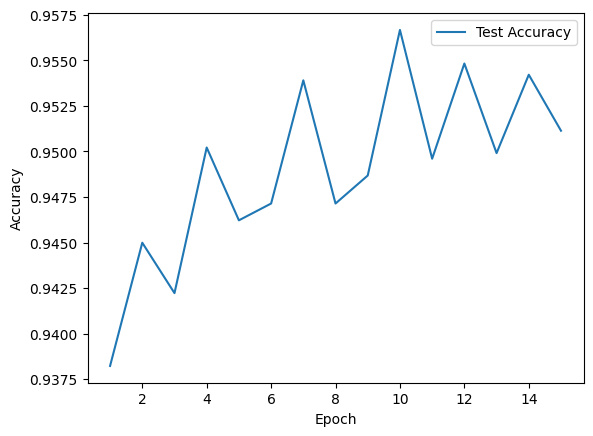

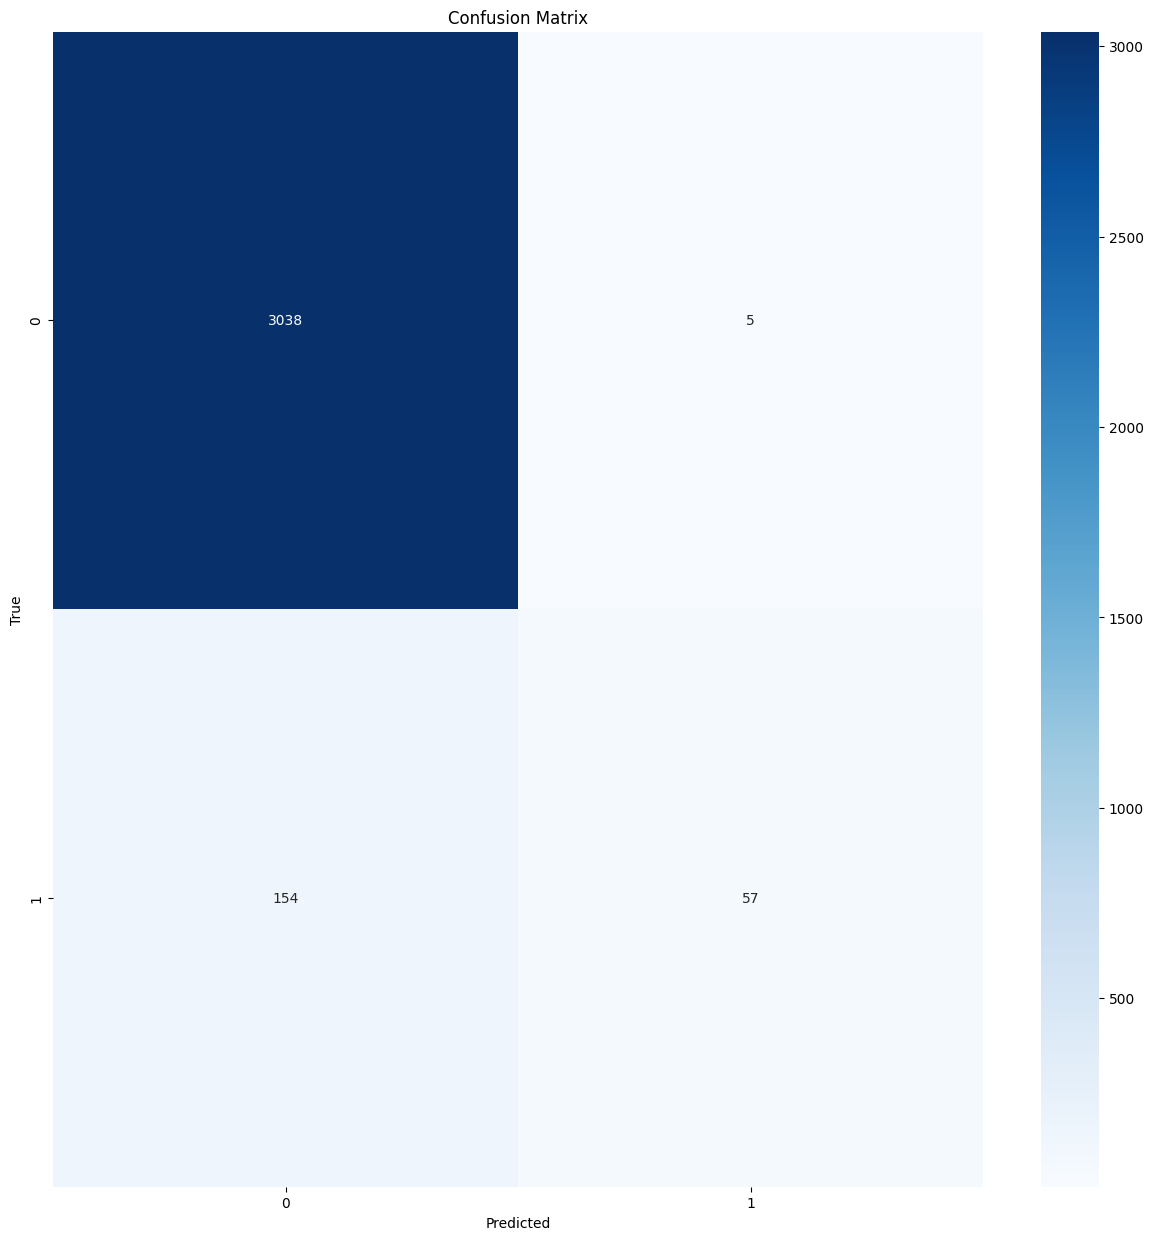

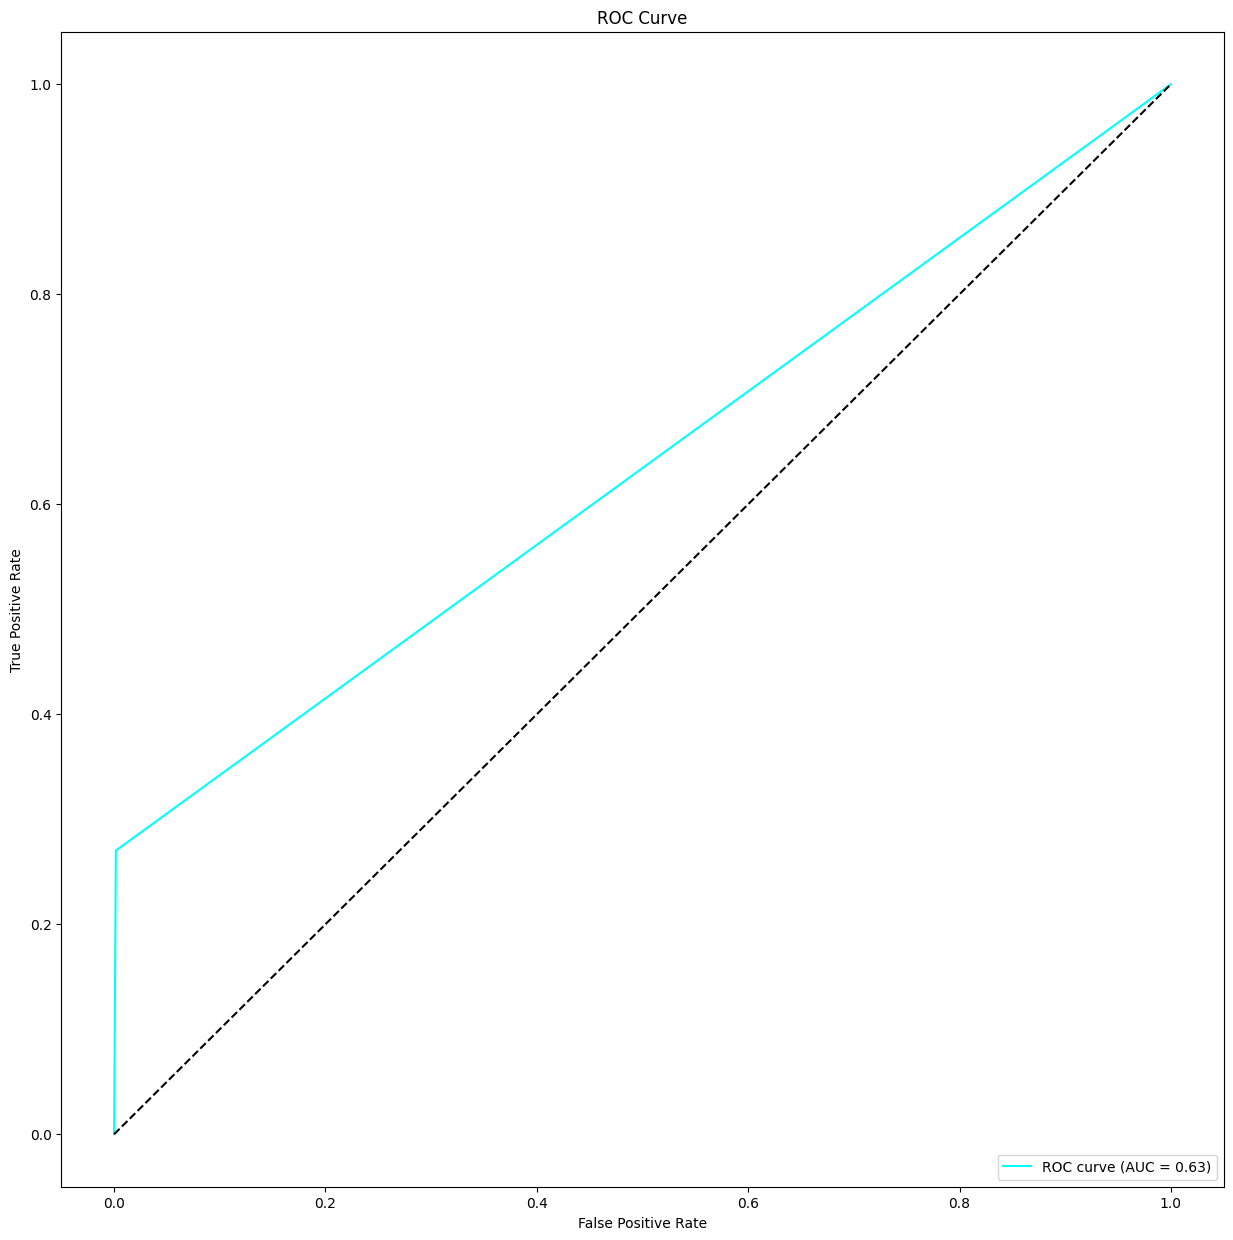

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      3043
         1.0       0.92      0.27      0.42       211

    accuracy                           0.95      3254
   macro avg       0.94      0.63      0.70      3254
weighted avg       0.95      0.95      0.94      3254



In [10]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=15, multilabel=multilabel, report=True, freeze_backbone=True)